In [2]:
#Learning Polys dataset for different combination of training data

import rascal
from rascal.representations import SphericalInvariants as SOAP

import ase
from ase import io
#from ase import atoms

import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

import soprano
from soprano.properties.nmr import *

import random

import soprano
from soprano.properties.nmr import *

import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from numpy.linalg import lstsq

import pandas as pd
from pandas import DataFrame

In [2]:
def keys_grabber(category):
    keys = list(pickle.load(open('Data/' + category + '/uid_index.pkl','rb')).keys())
    for i in keys:
        if not os.path.exists('Data/'+category+'/' + str(i) + '.magres'):
            keys.remove(i)
    return keys

def descriptor(cut, smooth):
    HYPERS = {
    'soap_type': 'PowerSpectrum',
    'interaction_cutoff': cut,
    'max_radial': 2,
    'max_angular': 6,
    'gaussian_sigma_constant': 0.5,
    'gaussian_sigma_type': 'Constant',
    'cutoff_smooth_width': smooth,
    'radial_basis': 'GTO',
    'inversion_symmetry': True,
    'normalize' : True
    }
    soap = SOAP(**HYPERS)
    return soap


def puller(keys, soap, category):
    #reading in all structures and creating all spectrums.
    for i in keys:
        #print(i)
        if keys.index(i) == 0:
            structure = ase.io.read('Data/' + category +'/'+str(i)+'.magres')
            spectrum = soap.transform(structure).get_features(soap)
            full_spec = spectrum
            iso = MSIsotropy.get(structure)
        else:
            structure = ase.io.read('Data/' + category +'/'+str(i)+'.magres')
            spectrum = soap.transform(structure).get_features(soap)
            full_spec = np.concatenate((full_spec,spectrum),axis =0)
            iso = np.concatenate((iso,MSIsotropy.get(structure)),axis=0)
    return full_spec, iso


def splitter(tr_f, no_sparse, full_spec, iso):
    #Randomly choosing representative matrix
    ids = range(len(full_spec)) #list of all ids
    tr_id = random.sample(ids, int(tr_f*len(full_spec)))
    sp_id = random.sample(tr_id, no_sparse)

    tr_sp = full_spec[tr_id] #training spectrums
    sp_sp = full_spec[sp_id] #representative/sparse spectrums

    tr_ta = iso[tr_id] #training target
    
    te_id = list(ids)
    for i in tr_id:
        te_id.remove(i)
    te_sp = full_spec[te_id]
    te_ta = iso[te_id]
    
    return sp_sp, tr_sp, tr_ta, te_sp, te_ta 
    
    
def kerneller(to_kernel, sp_sp, ker_exp):
    kernel = (to_kernel@sp_sp.T)**ker_exp
    return kernel

In [22]:
def model_maker(cat, cut, smo_cut, sp_size, ker_exp, reg):
    for i in cat:
        if cat.index(i) == 0:
            keys = keys_grabber(i)
            soap = descriptor(cut, smo_cut)
            full_spec, iso = puller(keys, soap, i)
        else:
            keys = keys_grabber(i)
            soap = descriptor(cut, smo_cut)
            full_spec_t, iso_t = puller(keys, soap, i)
            full_spec = np.concatenate((full_spec, full_spec_t))
            iso = np.concatenate((iso, iso_t))
    sp_sp, tr_sp, tr_ta, te_sp, te_ta = splitter(1, sp_size, full_spec, iso)
    
    KNM = kerneller(tr_sp, sp_sp, ker_exp)
    KMM = kerneller(sp_sp, sp_sp, ker_exp)
    res = lstsq(KNM.T @ KNM + reg * KMM, KNM.T @ tr_ta, rcond=None)
    c = res[0]
    
    return c, sp_sp

def predictor(cat, cut, smo_cut, ker_exp, reg, c, sp_sp):
    keys = keys_grabber(cat)
    soap = descriptor(cut, smo_cut)
    full_spec, iso = puller(keys, soap, cat)
    KTM = kerneller(full_spec, sp_sp, ker_exp)
    pred = KTM @ c
    rmse = mean_squared_error(iso, pred, squared=False)
    return iso, pred, rmse

def species_splitter(target, predicted):
    o_tar = []
    o_pred = []
    si_tar = []
    si_pred = []
    for i in target:
        if i < 350:
            o_tar.append(i)
        else:
            si_tar.append(i)
    for i in predicted:
        if i < 350:
            o_pred.append(i)
        else:
            si_pred.append(i)
    return o_tar, si_tar, o_pred, si_pred

def master_plot(cats, spec):
    ##params
    cut = 3.5
    smo_cut = 1
    sp_size = 1000
    ker_exp = 25
    reg = 1*10**-8    
    
    ##model
    c, sp_sp = model_maker(cats,cut,smo_cut, sp_size, ker_exp,reg)
    tar, pred, rmse = predictor('Polymorphs', cut, smo_cut, ker_exp, reg, c, sp_sp)
    o_tar, si_tar, o_pred, si_pred = species_splitter(tar, pred)
    
    #plot
    title = ' + '.join(cats)
    if spec == 'O':
        #O Rattle plot
        plt.plot([200,240],[200,240], color='grey', linestyle='-')
        plt.scatter(o_tar, o_pred, marker='s', color='red')
        rmse = round(mean_squared_error(o_tar, o_pred, squared=False),2)
        plt.xlabel('DFT calculated MS')
        plt.ylabel('ML predicted MS')
        plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
        plt.title(title)
    elif spec == 'Si':
        plt.scatter(si_tar, si_pred , marker='s', color='navy')
        plt.plot([430,455], [430,455], color='grey', linestyle='-')
        rmse = round(mean_squared_error(si_tar, si_pred, squared=False),2)
        plt.xlabel('DFT calculated MS')
        plt.ylabel('ML predicted MS')
        plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
        plt.title(title)

def master_error(cats):
    ##params
    cut = 3.5
    smo_cut = 1
    sp_size = 1000
    ker_exp = 25
    reg = 1*10**-8    
    
    ##model
    c, sp_sp = model_maker(cats,cut,smo_cut, sp_size, ker_exp,reg)
    tar, pred, rmse = predictor('Polymorphs', cut, smo_cut, ker_exp, reg, c, sp_sp)
    o_tar, si_tar, o_pred, si_pred = species_splitter(tar, pred)
    
    o_error = round(mean_squared_error(o_tar, o_pred, squared=False),2)
    si_error = round(mean_squared_error(si_tar, si_pred, squared=False),2)
    title = ' + '.join(cats)
    return title, o_error, si_error
        

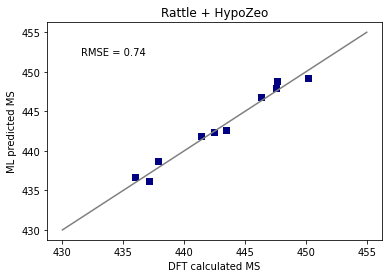

In [13]:
master_plot(['Rattle','HypoZeo'], 'Si')

In [37]:
import itertools
cats = ['Rattle', 'HypoZeo', 'AM0K', 'AM300K', 'MD_Distorted']
combos = list(itertools.combinations(cats,1))
titles = []
o_error = []
si_error = []

for i in combos:
    counter = 0
    tempo = []
    tempsi = []
    while counter < 10:
        t0, t1, t2 = master_error(i)
        tempo.append(t1)
        tempsi.append(t2)
        counter +=1
    titles.append(t0)
    o_error.append(sum(tempo)/len(tempo))
    si_error.append(sum(tempsi)/len(tempsi))

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(1, 0, 'Rattle + HypoZeo'),
  Text(2, 0, 'Rattle + AM0K'),
  Text(3, 0, 'Rattle + AM300K'),
  Text(4, 0, 'Rattle + MD_Distorted'),
  Text(5, 0, 'HypoZeo + AM0K'),
  Text(6, 0, 'HypoZeo + AM300K'),
  Text(7, 0, 'HypoZeo + MD_Distorted'),
  Text(8, 0, 'AM0K + AM300K'),
  Text(9, 0, 'AM0K + MD_Distorted'),
  Text(10, 0, 'AM300K + MD_Distorted')])

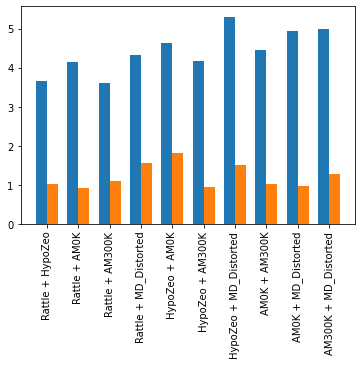

In [74]:
width = 0.35
x = np.arange(1,len(df['Combos'])+1)

ax = plt.subplot()
ax.bar(x-width/2,df['O Error'], width=width)
ax.bar(x+width/2,df['Si Error'], width=width)
ax.set_xticks(x)
ax.set_xticklabels(df['Combos'])
plt.xticks(rotation=90)

In [5]:
df2 = pd.read_csv('learn_polys_singlesets_rmse.csv')
df2.set_index('Combos', inplace=True)
df2['Average'] = (df2['O Error'] + df2['Si Error'])/2
df = pd.read_csv('learn_polys_pairsets_rmse.csv')
df['Average'] = (df['O Error'] + df['Si Error'])/2
df.set_index('Combos', inplace=True)

values = []
for i in df.index:
    temp = []
    for l in df2.index:
        if l in i:
            temp.append(df2.loc[l,'Average'])
    values.append(sum(temp)/len(temp))
df['Parent Average'] = values
df.head(20)

,Unnamed: 0,O Error,Si Error,Average,Parent Average
Combos,,,,,
Rattle + HypoZeo,0,3.650,1.035,2.3425,5.68475
Rattle + AM0K,1,4.140,0.922,2.5310,3.39750
Rattle + AM300K,2,3.610,1.088,2.3490,2.78275
Rattle + MD_Distorted,3,4.325,1.560,2.9425,3.23675
HypoZeo + AM0K,4,4.632,1.807,3.2195,6.43525
HypoZeo + AM300K,5,4.166,0.944,2.5550,5.82050
HypoZeo + MD_Distorted,6,5.304,1.507,3.4055,6.27450
AM0K + AM300K,7,4.466,1.034,2.7500,3.53325
AM0K + MD_Distorted,8,4.933,0.961,2.9470,3.98725


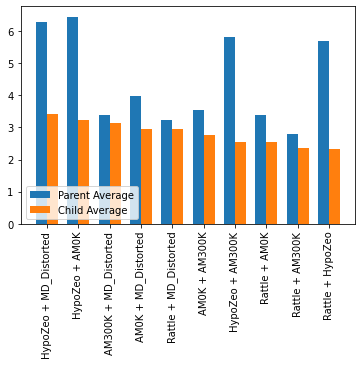

In [123]:
df.sort_values(by=['Average'], inplace=True, ascending=False)
width = 0.35
x = np.arange(len(df.index))

ax = plt.subplot()
ax.bar(x-width/2,df['Parent Average'], width=width, label='Parent Average')
ax.bar(x+width/2,df['Average'], width=width, label='Child Average')
ax.set_xticks(x)
ax.set_xticklabels(df.index)
plt.xticks(rotation=90)
plt.legend(loc='lower left')